# TASK 3.2
Development of a classification model for discriminating between 2 classes: benign and malignant. Usage of at least one pre-trained state-of-the-art architecture.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.x
import os
import itertools
import numpy as np
import tensorflow as tf
from sklearn.metrics import fbeta_score
import random as rn
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.applications import VGG16, InceptionV3, ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_process_input
from keras.applications.resnet50 import preprocess_input as resnet_process_input
from keras.applications.inception_v3 import preprocess_input as inception_process_input

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task3_2') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 128

# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## Utility function definition

### Loading training and test sets

In [ ]:
# Loading training set and test set
def load_training():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels


### Setting the seed

In [ ]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

### Plotting the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

### Plotting the ROC curve

In [ ]:
def plot_roc_curve(model, t_images, t_labels):
  probs = model.predict(t_images)
  fig2 = plt.figure()
  fpr, tpr, threshold = roc_curve(t_labels, probs)
  roc_auc = auc(fpr, tpr) 
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

### Plotting the accuracy and loss trends

In [ ]:
# Utility function for plotting accuracy and loss function
def performance_plot(history, model, test_generator):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

  t_images = test_generator[0][0]
  t_labels = test_generator[0][1]

  pred_labels = model.predict(t_images)
  pred_labels = np.rint(pred_labels)
  cm = confusion_matrix(t_labels, pred_labels)
  plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

  print(classification_report(t_labels, pred_labels, digits=4))

  plot_roc_curve(model, t_images,t_labels)


## Dataset creation
We take the original dataset with five labels: we discard the label '0', which correspond to baseline patch, because we are considering only the abnormalities, and we aggregate label '1' and '2', which both correspond to masses, and label '3' and '4', which are both calcifications.


In [ ]:
train_img, train_lab = load_training()
test_img, test_lab = load_test()

In [ ]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') * 0.003891051

# benign
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 3] = 0
# malignant
abnormality_labels[abnormality_labels == 2] = 1
abnormality_labels[abnormality_labels == 4] = 1


# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)

# bisogna ripetere i layer, le reti note sono trainate su imagenet (immagini a colori)
train_images = np.repeat(train_images, 3, axis=3)
valid_images = np.repeat(valid_images, 3, axis=3)

# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') * 0.003891051

# benign
test_labels[test_labels == 1] = 0
test_labels[test_labels == 3] = 0
# malignant
test_labels[test_labels == 2] = 1
test_labels[test_labels == 4] = 1

test_images = np.repeat(test_images, 3, axis=3)

print("Original training set")
print(abnormality_labels.shape)
print(abnormality_images.shape)
print("Training set")
print(train_labels.shape)
print(train_images.shape)
print("Validation set")
print(valid_labels.shape)
print(valid_images.shape)
print("Test set")
print(test_labels.shape)
print(test_images.shape)

print(train_images.max())

Original training set
(2676,)
(2676, 150, 150, 1)
Training set
(1873,)
(1873, 150, 150, 3)
Validation set
(803,)
(803, 150, 150, 3)
Test set
(336,)
(336, 150, 150, 3)
255.00003


## VGG 16



### Preprocessing

In [ ]:
vgg_train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

vgg_datagen = ImageDataGenerator(preprocessing_function=vgg_process_input)

In [ ]:
vgg_train_datagen.fit(train_images)
vgg_train_generator = vgg_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

vgg_validation_generator = vgg_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

vgg_test_generator = vgg_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition

In [ ]:
def vgg_creation(trainable = False, fc_dense = [512], summary = True):
    input_shape = (150, 150, 3)
    vgg_base = VGG16(weights='imagenet',
                    include_top = False,
                    input_shape=input_shape)

    vgg_base.trainable = trainable

    vgg = models.Sequential()
    vgg.add(vgg_base)
    vgg.add(layers.Flatten())
   
    for d in fc_dense:
      if d < 1:
        vgg.add(layers.Dropout(d))
      else:
        vgg.add(layers.Dense(d, activation='relu'))
    vgg.add(layers.Dense(1, activation='sigmoid'))
    
    if summary:
        vgg.summary()

    return vgg

58892288/58889256 [==============================] - 2s 0us/step


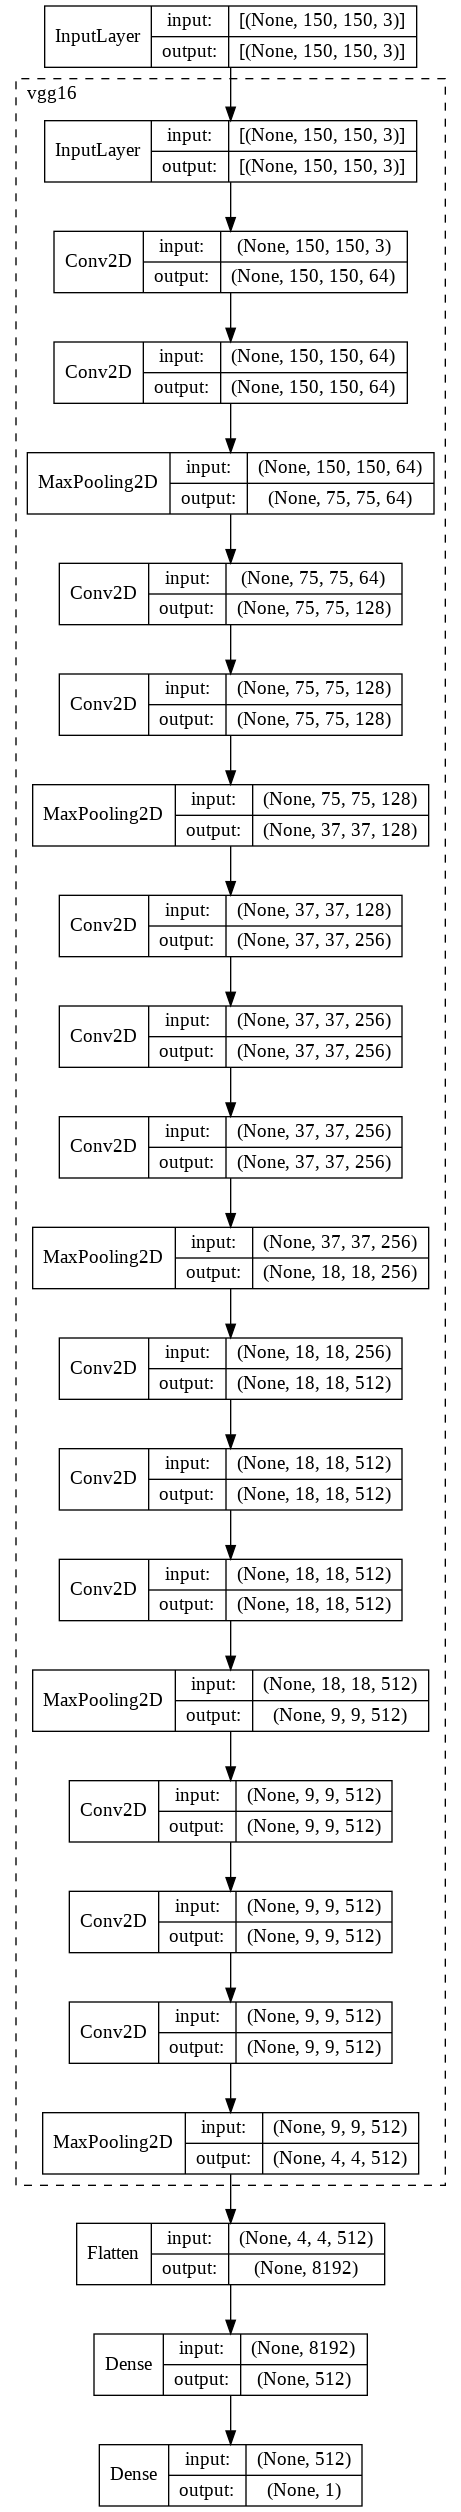

In [ ]:
# Plot the vgg architecture
vgg_architecture = vgg_creation(summary=False)
plot_model(vgg_architecture, to_file='vgg_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

### Features extraction

#### Vanilla
The original VGG16 is modified by adding a dense layer with 512 neurons giving a sigmoidal output while the convolutional basis is left as is.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 12s 801ms/step - loss: 3.1919 - acc: 0.5563 - val_loss: 0.5968 - val_acc: 0.6693

Epoch 00001: val_loss improved from inf to 0.59677, saving model to /content/drive/Shareddrives/Ver

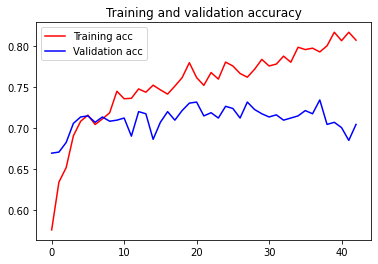

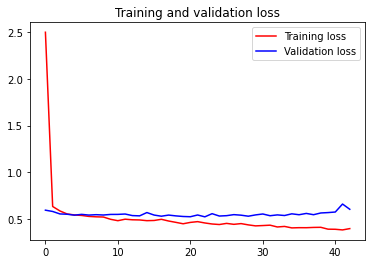

Specificity :  0.6073059360730594
Sensitivity :  0.6068376068376068


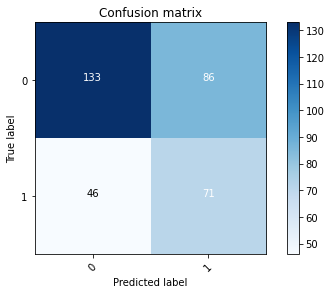

              precision    recall  f1-score   support

           0     0.7430    0.6073    0.6683       219
           1     0.4522    0.6068    0.5182       117

    accuracy                         0.6071       336
   macro avg     0.5976    0.6071    0.5933       336
weighted avg     0.6418    0.6071    0.6161       336



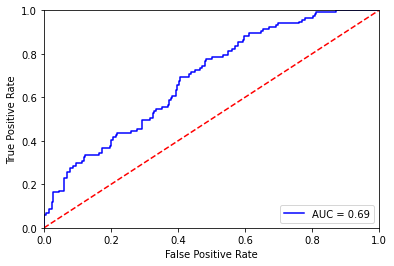

In [ ]:
set_seed()

vgg1 = vgg_creation()

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg1.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg1.save(os.path.join(MODEL_PATH, 'vgg1.h5'))
best_vgg1 = models.load_model(os.path.join(MODEL_PATH, 'vgg1_best.h5'))
performance_plot(history, best_vgg1, vgg_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg1_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.563


#### Smaller FC layer
We try to decrease the neurons of the last fully-connect block from 512 to 256.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 13s 907ms/step - loss: 2.6492 - acc: 0.5531 - val_loss: 0.5792 - val_acc: 0.6784

Epoch 00001: val_loss improved from inf to 0.57922, saving model to /content/drive/Shareddrives/Ver

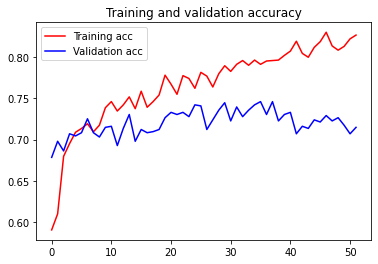

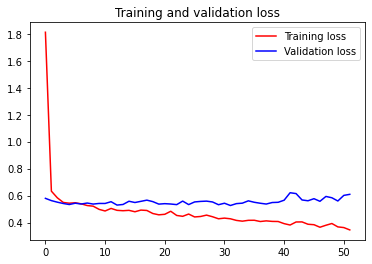

Specificity :  0.634703196347032
Sensitivity :  0.5897435897435898


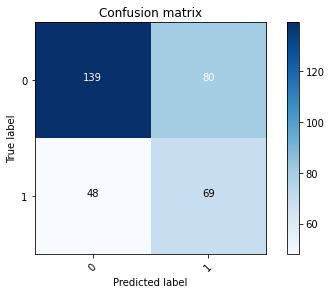

              precision    recall  f1-score   support

           0     0.7433    0.6347    0.6847       219
           1     0.4631    0.5897    0.5188       117

    accuracy                         0.6190       336
   macro avg     0.6032    0.6122    0.6018       336
weighted avg     0.6457    0.6190    0.6269       336



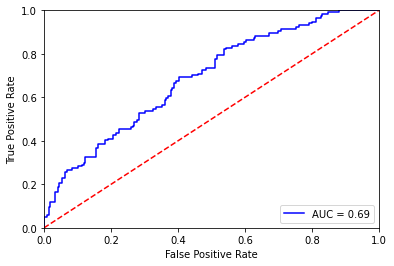

In [ ]:
set_seed()

vgg2 = vgg_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg2.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg2.save(os.path.join(MODEL_PATH, 'vgg2.h5'))
best_vgg2 = models.load_model(os.path.join(MODEL_PATH, 'vgg2_best.h5'))
performance_plot(history, best_vgg2, vgg_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg2_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.559


#### With dropout
Dropout is added at the end of the network to mitigate overfitting.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 13s 923ms/step - loss: 3.0313 - acc: 0.5458 - val

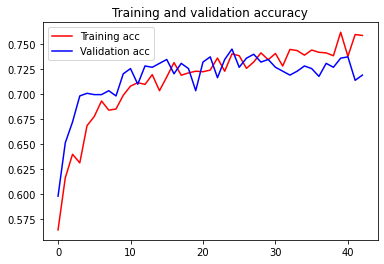

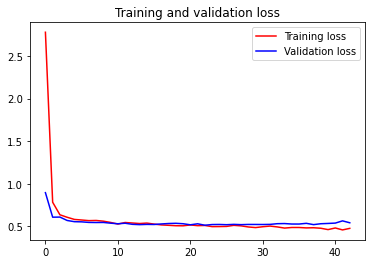

Specificity :  0.6575342465753424
Sensitivity :  0.5641025641025641


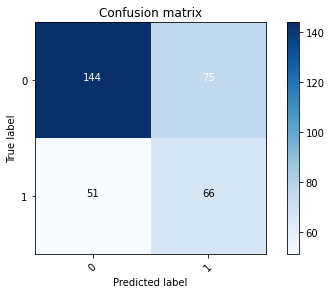

              precision    recall  f1-score   support

           0     0.7385    0.6575    0.6957       219
           1     0.4681    0.5641    0.5116       117

    accuracy                         0.6250       336
   macro avg     0.6033    0.6108    0.6036       336
weighted avg     0.6443    0.6250    0.6316       336



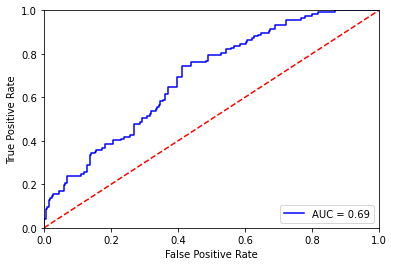

In [ ]:
set_seed()

vgg3 = vgg_creation(fc_dense=[0.5, 512])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg3_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg3.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg3.save(os.path.join(MODEL_PATH, 'vgg3.h5'))
best_vgg3 = models.load_model(os.path.join(MODEL_PATH, 'vgg3_best.h5'))
performance_plot(history, best_vgg3, vgg_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg3_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.542


#### 2 FC layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 19,041,089
Trainable params: 4,326,401
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 13s 875ms/step - loss: 3.6601 - acc: 0.5434 - val

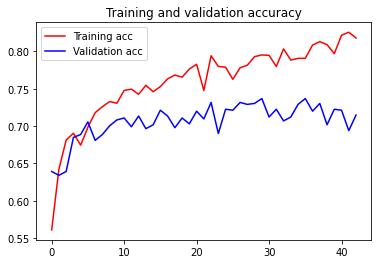

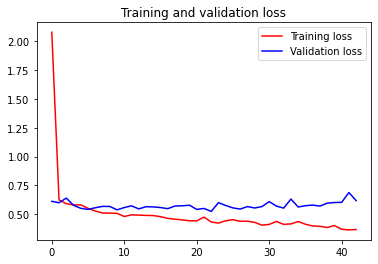

Specificity :  0.6575342465753424
Sensitivity :  0.5982905982905983


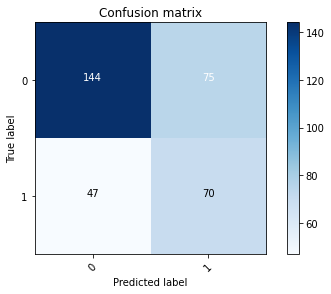

              precision    recall  f1-score   support

           0     0.7539    0.6575    0.7024       219
           1     0.4828    0.5983    0.5344       117

    accuracy                         0.6369       336
   macro avg     0.6183    0.6279    0.6184       336
weighted avg     0.6595    0.6369    0.6439       336



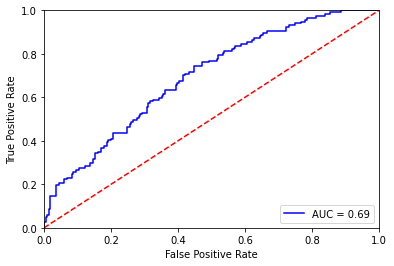

In [ ]:
set_seed()

vgg4 = vgg_creation(fc_dense=[512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg4_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg4.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg4.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg4.save(os.path.join(MODEL_PATH, 'vgg4.h5'))
best_vgg4 = models.load_model(os.path.join(MODEL_PATH, 'vgg4_best.h5'))
performance_plot(history, best_vgg4, vgg_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg4_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.571


### Fine Tuning

#### 1 layer

In [ ]:
vgg16_1_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg4_best.h5'))

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_1_layers.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_1_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

vgg16_1_layers.summary()
for i, layer in enumerate(vgg16_1_layers.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 19,041,089
Trainable params: 6,686,209
Non-trainable params: 12,354,880
_________________________________________________________________
0 input_1 False <tensorflow.python.keras.preprocessing.image.NumpyArrayIterator object at 0x7f986950c3

Epoch 1/50
14/14 [==============================] - 13s 908ms/step - loss: 1.7882 - acc: 0.5855 - val_loss: 0.5958 - val_acc: 0.6393

Epoch 00001: val_loss improved from inf to 0.59582, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/vgg16_1_layers_best.h5
Epoch 2/50
14/14 [==============================] - 12s 876ms/step - loss: 0.6104 - acc: 0.6561 - val_loss: 0.5583 - val_acc: 0.6979

Epoch 00002: val_loss improved from 0.59582 to 0.55833, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/vgg16_1_layers_best.h5
Epoch 3/50
14/14 [==============================] - 12s 880ms/step - loss: 0.5842 - acc: 0.6875 - val_loss: 0.5440 - val_acc: 0.6836

Epoch 00003: val_loss improved from 0.55833 to 0.54400, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/vgg16_1_layers_best.h5
Epoch 4/50
14/14 [==============================] - 12s 855ms/step - loss: 0.5323 - ac

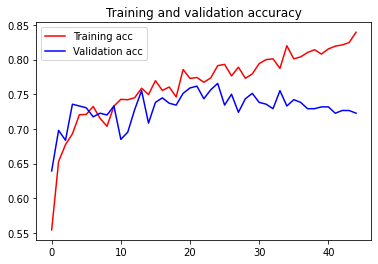

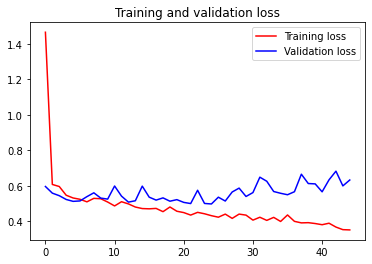

Specificity :  0.6301369863013698
Sensitivity :  0.6324786324786325


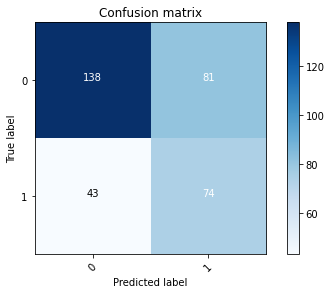

              precision    recall  f1-score   support

           0     0.7624    0.6301    0.6900       219
           1     0.4774    0.6325    0.5441       117

    accuracy                         0.6310       336
   macro avg     0.6199    0.6313    0.6171       336
weighted avg     0.6632    0.6310    0.6392       336



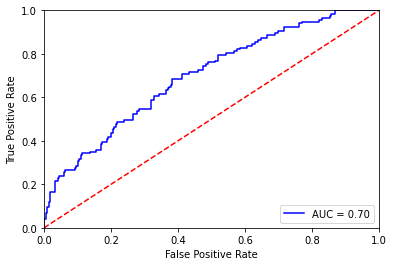

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg16_1_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg16_1_layers.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 50,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg16_1_layers.save(os.path.join(MODEL_PATH, 'vgg16_1_layers.h5'))
best_vgg16_1_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_1_layers_best.h5'))
performance_plot(history, best_vgg16_1_layers, vgg_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg16_1_layers_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.594


#### 2 layers

We are applying the same process iteratively, this time starting from the 1-layer fine-tuned model and unfreezing the penultimate convolutional layer.

In [ ]:
vgg16_2_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_1_layers_best.h5'))

# Fine tuning: unfreeze the last 2 convolutional layers
for layer in vgg16_2_layers.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_2_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

vgg16_2_layers.summary()
for i, layer in enumerate(vgg16_2_layers.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Epoch 1/50
14/14 [==============================] - 13s 901ms/step - loss: 5.4846 - acc: 0.6072 - val_loss: 0.7651 - val_acc: 0.6211

Epoch 00001: val_loss improved from inf to 0.76514, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/vgg16_2_layers_best.h5
Epoch 2/50
14/14 [==============================] - 13s 911ms/step - loss: 0.7443 - acc: 0.6317 - val_loss: 0.5862 - val_acc: 0.6523

Epoch 00002: val_loss improved from 0.76514 to 0.58619, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/vgg16_2_layers_best.h5
Epoch 3/50
14/14 [==============================] - 13s 894ms/step - loss: 0.5809 - acc: 0.6663 - val_loss: 0.6531 - val_acc: 0.6081

Epoch 00003: val_loss did not improve from 0.58619
Epoch 4/50
14/14 [==============================] - 13s 893ms/step - loss: 0.5756 - acc: 0.6550 - val_loss: 0.5532 - val_acc: 0.6771

Epoch 00004: val_loss improved from 0.58619 to 0.55321, saving model to /

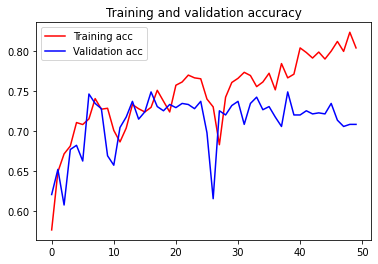

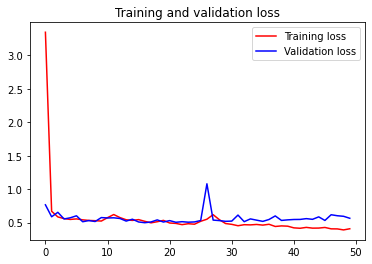

Specificity :  0.7397260273972602
Sensitivity :  0.6495726495726496


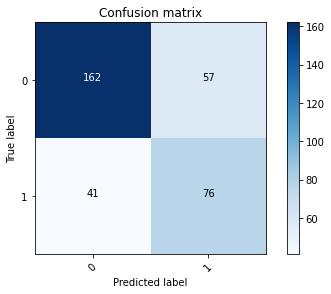

              precision    recall  f1-score   support

           0     0.7980    0.7397    0.7678       219
           1     0.5714    0.6496    0.6080       117

    accuracy                         0.7083       336
   macro avg     0.6847    0.6946    0.6879       336
weighted avg     0.7191    0.7083    0.7121       336



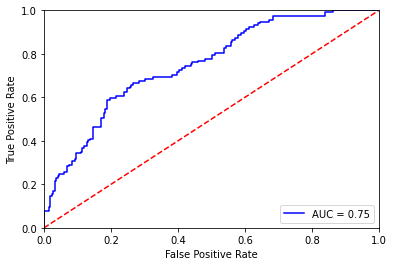

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg16_2_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = vgg16_2_layers.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=50,
    class_weight = class_weights,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg16_2_layers.save(os.path.join(MODEL_PATH, 'vgg16_2_layers.h5'))
best_vgg16_2_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_2_layers_best.h5'))
performance_plot(history, best_vgg16_2_layers, vgg_test_generator)


In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/vgg16_2_layers_best.h5'))
t_images = vgg_test_generator[0][0]
t_labels = vgg_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.632


## Resnet50

### Preprocessing
We perform Data Augmentation with the training set in order to increase the number of data. 

In [ ]:
resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

resnet_datagen = ImageDataGenerator(preprocessing_function=resnet_process_input)

In [ ]:
# Data augmentation for training and validation set 
resnet_train_datagen.fit(train_images)
resnet_train_generator = resnet_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

resnet_validation_generator = resnet_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

resnet_test_generator = resnet_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition

In [ ]:
def resnet_creation(trainable = False, fc_dense = [512], summary=True):
    resnet_base = ResNet50(weights='imagenet',
                           include_top = False, # togliamo l'ultimo livello per classificare quello che vogliamo
                           input_shape=(150, 150, 3))

    # set_trainable = False
    # for layer in resnet.layers:
    #     layer.trainable = set_trainable
    resnet_base.trainable = trainable

    resnet = models.Sequential()
    resnet.add(resnet_base)

    resnet.add(layers.Flatten())

    for d in fc_dense:
      if d < 1:
        resnet.add(layers.Dropout(d))
      else:
        resnet.add(layers.Dense(d, activation='relu'))
    resnet.add(layers.Dense(1, activation='sigmoid'))

    if summary:
        resnet.summary()

    return resnet

In [ ]:
# Plot the resnet archtecture
resnet_architecture = resnet_creation(summary=False)
plot_model(resnet_architecture, to_file='resnet_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

### Features extraction


#### Vanilla

94773248/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 49,803,137
Trainable params: 26,215,425
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 16s 936ms/step - loss: 8.6066 - acc: 0.5732 - val_loss: 0.6613 - val_acc: 0.7031

Epoch 00001: val_loss improved fr

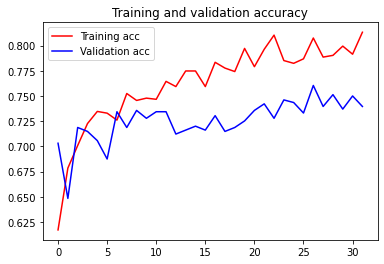

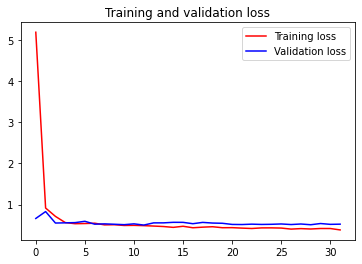

Specificity :  0.6712328767123288
Sensitivity :  0.6581196581196581


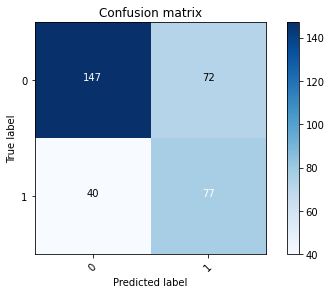

              precision    recall  f1-score   support

           0     0.7861    0.6712    0.7241       219
           1     0.5168    0.6581    0.5789       117

    accuracy                         0.6667       336
   macro avg     0.6514    0.6647    0.6515       336
weighted avg     0.6923    0.6667    0.6736       336



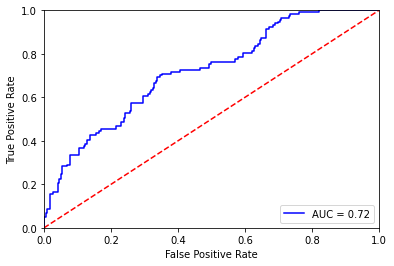

In [ ]:
set_seed()

resnet1 = resnet_creation()

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'resnet1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet1.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = resnet1.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)
resnet1.save(os.path.join(MODEL_PATH, 'resnet1.h5'))
best_resnet1 = models.load_model(os.path.join(MODEL_PATH, 'resnet1_best.h5'))
performance_plot(history, best_resnet1, resnet_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/resnet1_best.h5'))
t_images = resnet_test_generator[0][0]
t_labels = resnet_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.624


#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 16s 961ms/step - loss: 5.4375 - acc: 0.5414 - val_loss: 1.6177 - val_acc: 0.5169

Epoch 00001: val_loss improved from inf to 1.61768, saving model to /content/drive/Shareddrives/Ve

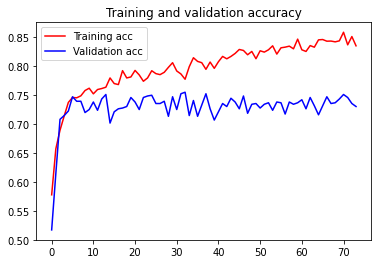

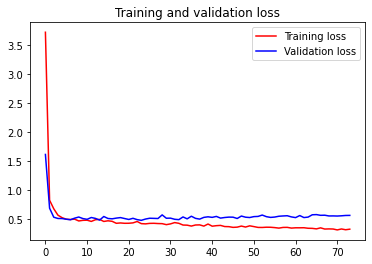

Specificity :  0.726027397260274
Sensitivity :  0.6324786324786325


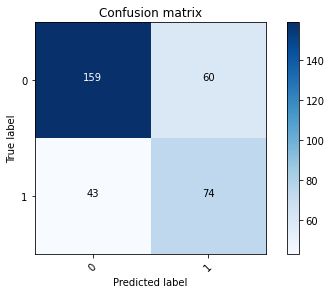

              precision    recall  f1-score   support

           0     0.7871    0.7260    0.7553       219
           1     0.5522    0.6325    0.5896       117

    accuracy                         0.6935       336
   macro avg     0.6697    0.6793    0.6725       336
weighted avg     0.7053    0.6935    0.6976       336



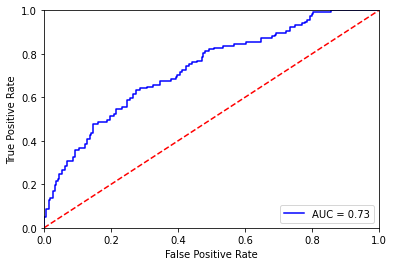

In [ ]:
set_seed()

resnet2 = resnet_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'resnet2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

resnet2.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = resnet2.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet2.save(os.path.join(MODEL_PATH, 'resnet2.h5'))

best_resnet2 = models.load_model(os.path.join(MODEL_PATH, 'resnet2_best.h5'))

performance_plot(history, best_resnet2, resnet_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/resnet2_best.h5'))
t_images = resnet_test_generator[0][0]
t_labels = resnet_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.615


#### With dropout

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 49,803,137
Trainable params: 26,215,425
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 16s 969ms/step - loss: 5.3597 - acc: 0.5576 - va

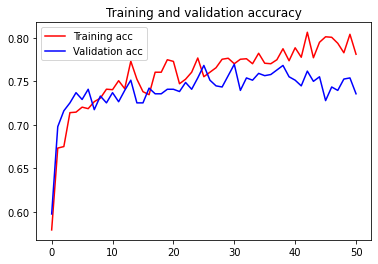

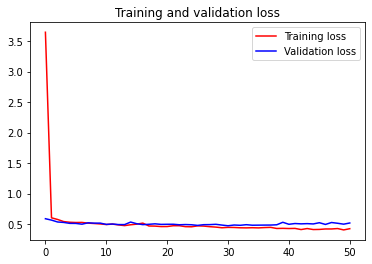

Specificity :  0.6164383561643836
Sensitivity :  0.7863247863247863


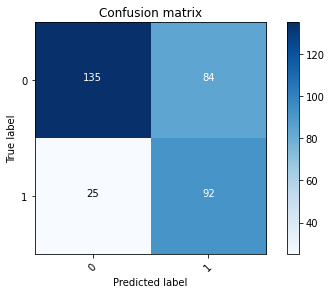

              precision    recall  f1-score   support

           0     0.8438    0.6164    0.7124       219
           1     0.5227    0.7863    0.6280       117

    accuracy                         0.6756       336
   macro avg     0.6832    0.7014    0.6702       336
weighted avg     0.7320    0.6756    0.6830       336



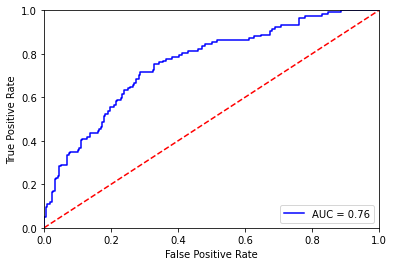

In [ ]:
set_seed()

resnet3 = resnet_creation(fc_dense=[0.5, 512])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'resnet3_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet3.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = resnet3.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet3.save(os.path.join(MODEL_PATH, 'resnet3.h5'))
best_resnet3 = models.load_model(os.path.join(MODEL_PATH, 'resnet3_best.h5'))
performance_plot(history, best_resnet3, resnet_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/resnet3_best.h5'))
t_images = resnet_test_generator[0][0]
t_labels = resnet_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.714


#### 2 FC layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 49,934,209
Trainable params: 26,346,497
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 15s 942ms/step - loss: 6.1702 - acc: 0.5259 - va

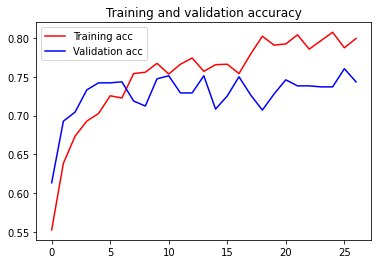

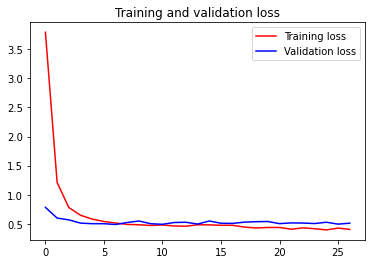

Specificity :  0.7077625570776256
Sensitivity :  0.6239316239316239


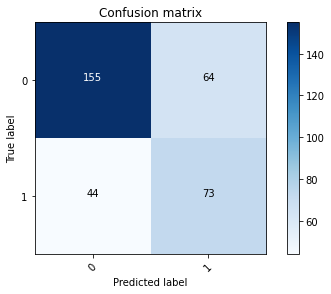

              precision    recall  f1-score   support

           0     0.7789    0.7078    0.7416       219
           1     0.5328    0.6239    0.5748       117

    accuracy                         0.6786       336
   macro avg     0.6559    0.6658    0.6582       336
weighted avg     0.6932    0.6786    0.6835       336



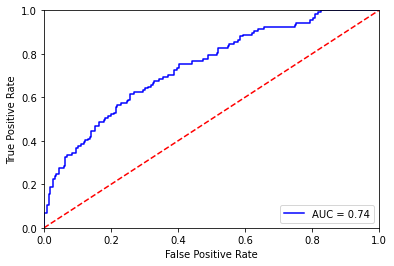

In [ ]:
set_seed()

resnet4 = resnet_creation(fc_dense=[512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'resnet4_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet4.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = resnet4.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet4.save(os.path.join(MODEL_PATH, 'resnet4.h5'))
best_resnet4 = models.load_model(os.path.join(MODEL_PATH, 'resnet4_best.h5'))
performance_plot(history, best_resnet4, resnet_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/resnet4_best.h5'))
t_images = resnet_test_generator[0][0]
t_labels = resnet_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.603


### Fine tuning

#### 2 layers

In [ ]:
resnet_1_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet3_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in resnet_1_layers.get_layer('resnet50').layers:
    if layer.name in ('conv5_block3_3_conv', 'conv5_block3_2_conv'):
        layer.trainable = True
    else:
        layer.trainable = False

resnet_1_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['acc'])

resnet_1_layers.summary()
for i, layer in enumerate(resnet_1_layers.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 49,803,137
Trainable params: 29,625,857
Non-trainable params: 20,177,280
_________________________________________________________________
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad 

Epoch 1/100
14/14 [==============================] - 15s 857ms/step - loss: 0.4413 - acc: 0.7656 - val_loss: 0.4778 - val_acc: 0.7682

Epoch 00001: val_loss improved from inf to 0.47775, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2/resnet_1_layers_best.h5
Epoch 2/100
14/14 [==============================] - 11s 745ms/step - loss: 0.4306 - acc: 0.7977 - val_loss: 0.4761 - val_acc: 0.7669

Epoch 00002: val_loss improved from 0.47775 to 0.47609, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2/resnet_1_layers_best.h5
Epoch 3/100
14/14 [==============================] - 10s 735ms/step - loss: 0.4623 - acc: 0.7666 - val_loss: 0.4719 - val_acc: 0.7682

Epoch 00003: val_loss improved from 0.47609 to 0.47186, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2/resnet_1_layers_best.h5
Epoch 4/100
14/14 [==============================] - 10s 738ms/step - loss: 0.4414 - a

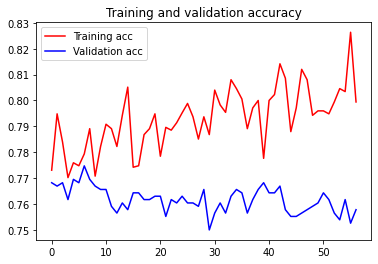

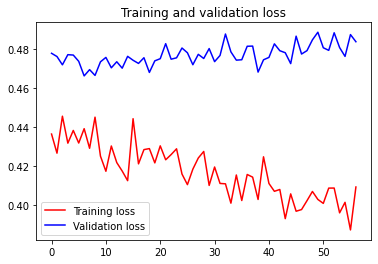

Specificity :  0.6986301369863014
Sensitivity :  0.7008547008547008


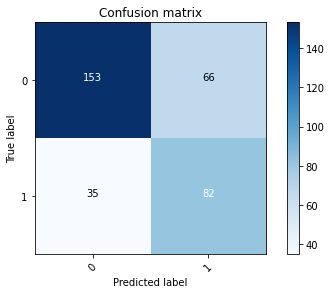

              precision    recall  f1-score   support

           0     0.8138    0.6986    0.7518       219
           1     0.5541    0.7009    0.6189       117

    accuracy                         0.6994       336
   macro avg     0.6839    0.6997    0.6854       336
weighted avg     0.7234    0.6994    0.7055       336



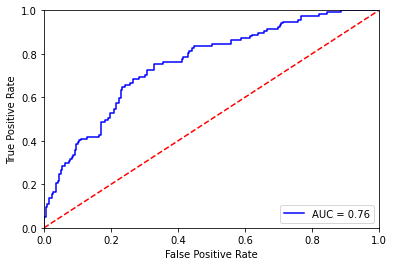

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'resnet_1_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = resnet_1_layers.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet_1_layers.save(os.path.join(MODEL_PATH, 'resnet_1_layers.h5'))
best_resnet_1_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet_1_layers_best.h5'))
performance_plot(history, best_resnet_1_layers, resnet_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/resnet_1_layers_best.h5'))
t_images = resnet_test_generator[0][0]
t_labels = resnet_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.666


## Inception

### Preprocessing

In [ ]:
inception_train_datagen = ImageDataGenerator(
    preprocessing_function=inception_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

inception_datagen = ImageDataGenerator(preprocessing_function=inception_process_input)

In [ ]:
inception_train_datagen.fit(train_images)
inception_train_generator = inception_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

inception_validation_generator = inception_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

inception_test_generator = inception_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition

In [ ]:
def inception_creation(fc_dense = [512], summary=True):
    inception_base = InceptionV3(weights='imagenet',
                    include_top=False, # togliamo l'ultimo livello per classificare quello che vogliamo
                    input_shape=(150, 150, 3))

    inception_base.trainable = False

    inception = models.Sequential()
    inception.add(inception_base)
    inception.add(layers.Flatten())

    for d in fc_dense:
      if d < 1:
        inception.add(layers.Dropout(d))
      else:
        inception.add(layers.Dense(d, activation='relu'))
    
    inception.add(layers.Dense(1, activation='sigmoid'))
    inception.summary()

    return inception


In [ ]:
# Plot the inception archtecture
inception_architecture = inception_creation(summary=False)
plot_model(inception_architecture, to_file='inception_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

Output hidden; open in https://colab.research.google.com to view.

### Features extraction

#### Vanilla

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
14/14 [==============================] - 19s 696ms/step - loss: 2.0985 - acc: 0.5717 - val_loss: 0.6727 - val_acc: 0.6432

Epoch 00001: val_loss improved from inf to 0.67267, saving model to /content/drive/Shareddrives/Vern

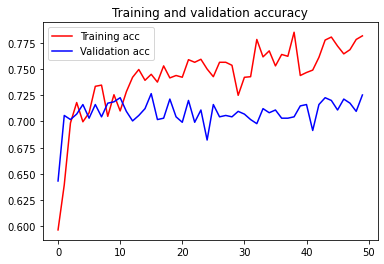

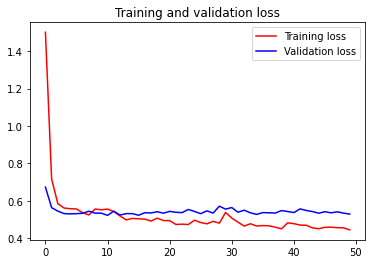

Specificity :  0.6621004566210046
Sensitivity :  0.6666666666666666


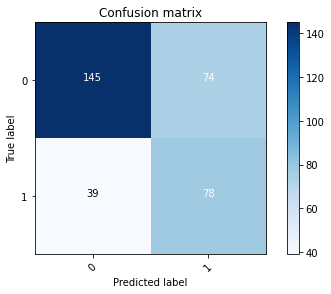

              precision    recall  f1-score   support

           0     0.7880    0.6621    0.7196       219
           1     0.5132    0.6667    0.5799       117

    accuracy                         0.6637       336
   macro avg     0.6506    0.6644    0.6498       336
weighted avg     0.6923    0.6637    0.6710       336



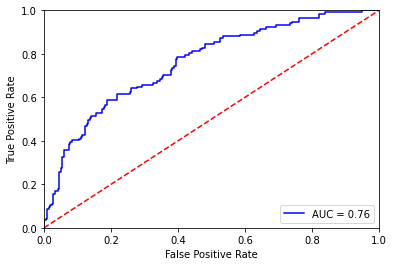

In [ ]:
set_seed() 

inception1 = inception_creation()

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

inception1.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception1.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=50,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception1.save(os.path.join(MODEL_PATH, 'inception1.h5'))
best_inception1 = models.load_model(os.path.join(MODEL_PATH, 'inception1_best.h5'))
performance_plot(history, best_inception1, inception_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception1_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.629


#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
14/14 [==============================] - 13s 696ms/step - loss: 1.4682 - acc: 0.5708 - val_loss: 0.6921 - val_acc: 0.5599

Epoch 00001: val_loss improved from inf to 0.69208, saving model to /content/drive/Shareddrives/Vern

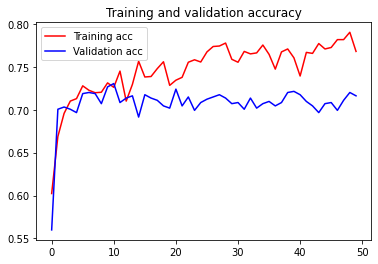

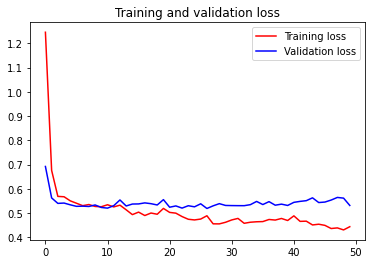

Specificity :  0.6986301369863014
Sensitivity :  0.6495726495726496


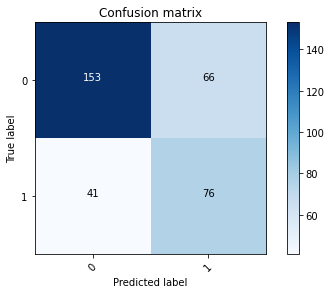

              precision    recall  f1-score   support

           0     0.7887    0.6986    0.7409       219
           1     0.5352    0.6496    0.5869       117

    accuracy                         0.6815       336
   macro avg     0.6619    0.6741    0.6639       336
weighted avg     0.7004    0.6815    0.6873       336



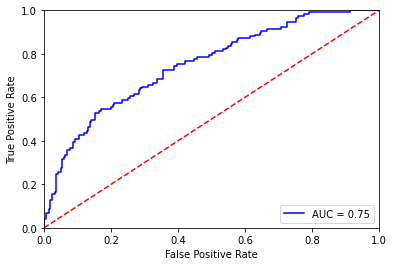

In [ ]:
set_seed() 

inception2 = inception_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

inception2.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception2.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=50,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception2.save(os.path.join(MODEL_PATH, 'inception2.h5'))

best_inception2 = models.load_model(os.path.join(MODEL_PATH, 'inception2_best.h5'))

performance_plot(history, best_inception2, inception_test_generator)


In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception2_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.623


#### Dropout

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
14/14 [==============================] - 13s 693ms/step - loss: 2.5635 - acc: 0.5143 - val_

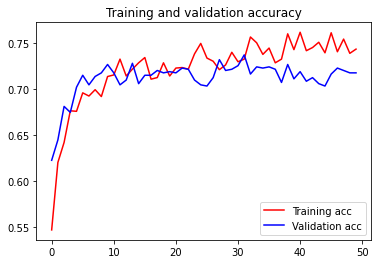

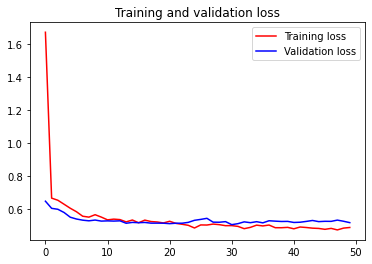

Specificity :  0.5981735159817352
Sensitivity :  0.7350427350427351


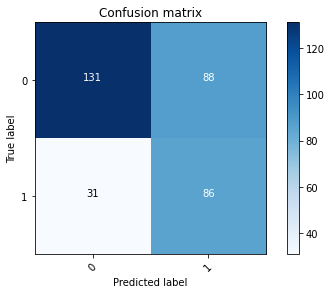

              precision    recall  f1-score   support

           0     0.8086    0.5982    0.6877       219
           1     0.4943    0.7350    0.5911       117

    accuracy                         0.6458       336
   macro avg     0.6514    0.6666    0.6394       336
weighted avg     0.6992    0.6458    0.6540       336



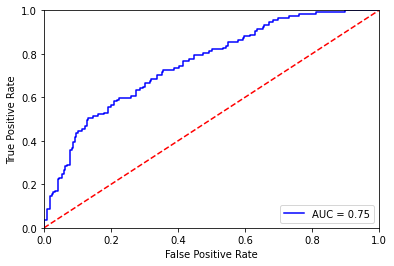

In [ ]:
set_seed() 

inception4 = inception_creation(fc_dense=[0.5, 512])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception4_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

inception4.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception4.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=50,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception4.save(os.path.join(MODEL_PATH, 'inception4.h5'))
best_inception4 = models.load_model(os.path.join(MODEL_PATH, 'inception4_best.h5'))
performance_plot(history, best_inception4, inception_test_generator)


In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception4_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.670


#### With dropout and 2 FC layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 31,372,065
Trainable params: 9,569,281
Non-trainable params: 21,802,784
____________________________________

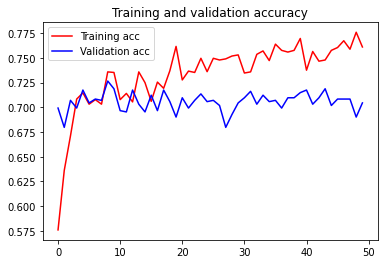

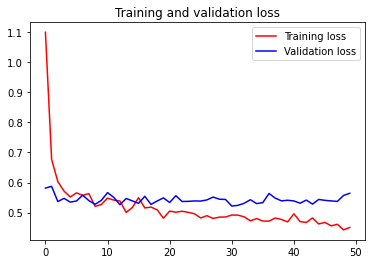

Specificity :  0.7123287671232876
Sensitivity :  0.6837606837606838


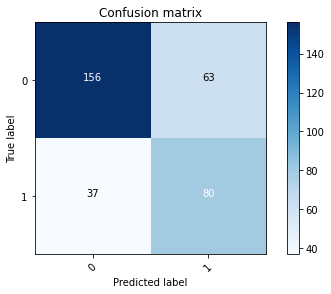

              precision    recall  f1-score   support

           0     0.8083    0.7123    0.7573       219
           1     0.5594    0.6838    0.6154       117

    accuracy                         0.7024       336
   macro avg     0.6839    0.6980    0.6863       336
weighted avg     0.7216    0.7024    0.7079       336



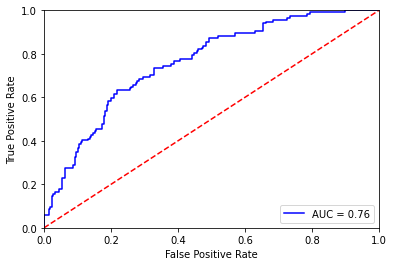

In [ ]:
set_seed() 

inception5 = inception_creation(fc_dense=[0.5, 512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception5_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

inception5.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception5.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=50,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception5.save(os.path.join(MODEL_PATH, 'inception5.h5'))
best_inception5 = models.load_model(os.path.join(MODEL_PATH, 'inception5_best.h5'))
performance_plot(history, best_inception5, inception_test_generator)


In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception5_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.655


#### 2 FC layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 31,372,065
Trainable params: 9,569,281
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 13s 715ms/step - loss: 1.5116 - acc: 0.5384 - val

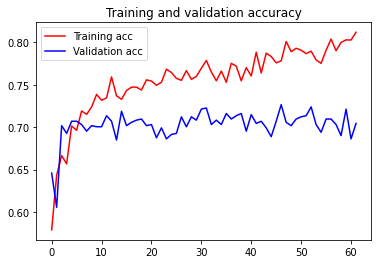

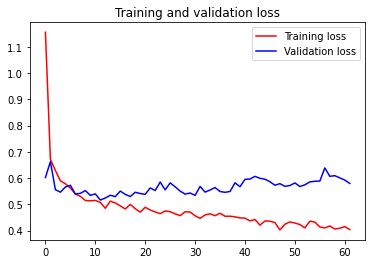

Specificity :  0.726027397260274
Sensitivity :  0.6239316239316239


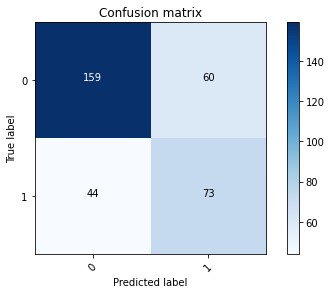

              precision    recall  f1-score   support

           0     0.7833    0.7260    0.7536       219
           1     0.5489    0.6239    0.5840       117

    accuracy                         0.6905       336
   macro avg     0.6661    0.6750    0.6688       336
weighted avg     0.7016    0.6905    0.6945       336



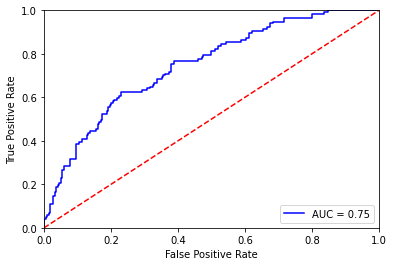

In [ ]:
set_seed() 

inception6 = inception_creation(fc_dense=[512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception6_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

inception6.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception6.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception6.save(os.path.join(MODEL_PATH, 'inception6.h5'))
best_inception6 = models.load_model(os.path.join(MODEL_PATH, 'inception6_best.h5'))
performance_plot(history, best_inception6, inception_test_generator)


In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception6_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.607


### Fine tuning

#### 2 layers

In [ ]:
inception_2_layers = models.load_model(os.path.join(MODEL_PATH, 'inception4_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in inception_2_layers.get_layer('inception_v3').layers:
    if layer.name in ('conv2d_93'): #, 'conv2d_92'):
        layer.trainable = True
    else:
        layer.trainable = False

inception_2_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['acc'])

inception_2_layers.summary()
for i, layer in enumerate(inception_2_layers.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 31,240,993
Trainable params: 9,887,585
Non-trainable params: 21,353,408
_________________________________________________________________
0 input_1 False
1 conv2d True
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_

Epoch 1/100
14/14 [==============================] - 14s 726ms/step - loss: 0.5025 - acc: 0.7445 - val_loss: 0.5122 - val_acc: 0.7214

Epoch 00001: val_loss improved from inf to 0.51219, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/inception_2_layers_best.h5
Epoch 2/100
14/14 [==============================] - 9s 632ms/step - loss: 0.4887 - acc: 0.7489 - val_loss: 0.5146 - val_acc: 0.7279

Epoch 00002: val_loss did not improve from 0.51219
Epoch 3/100
14/14 [==============================] - 9s 651ms/step - loss: 0.5189 - acc: 0.7242 - val_loss: 0.5119 - val_acc: 0.7331

Epoch 00003: val_loss improved from 0.51219 to 0.51193, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task3_2_2/inception_2_layers_best.h5
Epoch 4/100
14/14 [==============================] - 9s 641ms/step - loss: 0.4861 - acc: 0.7413 - val_loss: 0.5185 - val_acc: 0.7253

Epoch 00004: val_loss did not improve from 0.51193
Epoch 5/100
1

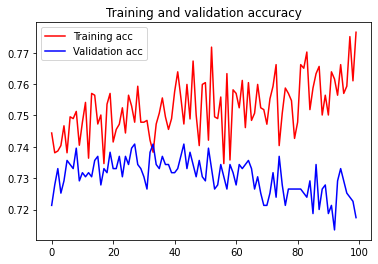

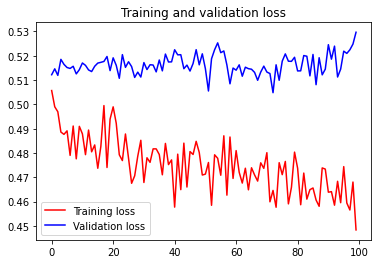

Specificity :  0.684931506849315
Sensitivity :  0.6837606837606838


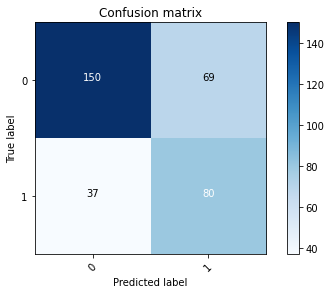

              precision    recall  f1-score   support

           0     0.8021    0.6849    0.7389       219
           1     0.5369    0.6838    0.6015       117

    accuracy                         0.6845       336
   macro avg     0.6695    0.6843    0.6702       336
weighted avg     0.7098    0.6845    0.6911       336



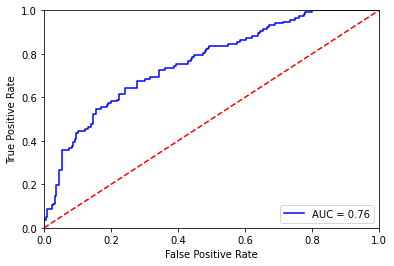

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception_2_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=30)

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)
class_weights = dict(enumerate(class_weights))

history = inception_2_layers.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    class_weight = class_weights,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception_2_layers.save(os.path.join(MODEL_PATH, 'inception_2_layers.h5'))
best_inception_2_layers = models.load_model(os.path.join(MODEL_PATH, 'inception_2_layers_best.h5'))
performance_plot(history, best_inception_2_layers, inception_test_generator)

In [ ]:
model = models.load_model(os.path.join(DIR_PATH, 'models/models_task3_2/inception_2_layers_best.h5'))
t_images = inception_test_generator[0][0]
t_labels = inception_test_generator[0][1]
result = model.predict(t_images)
f = fbeta_score(t_labels, np.rint(result), beta=2.0)
print('Result: f2_score=%.3f' % (f))

Result: f2_score=0.648


## Error Analysis

Number of test images: 336
Mispredictions: 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


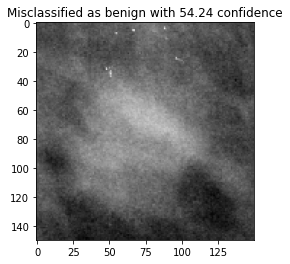

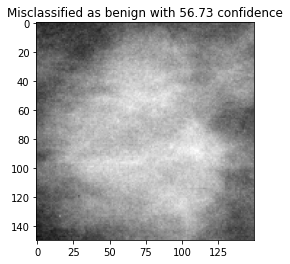

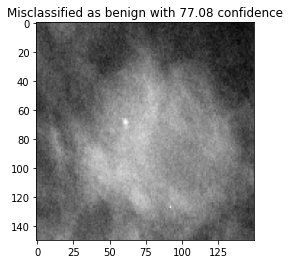

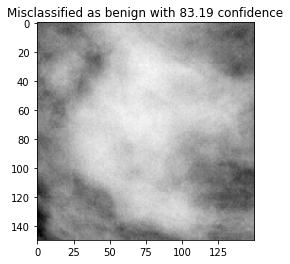

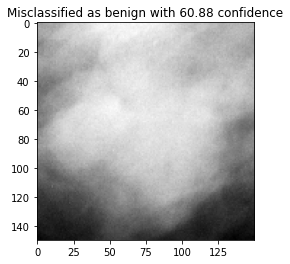

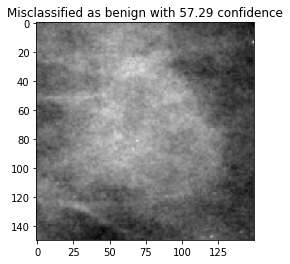

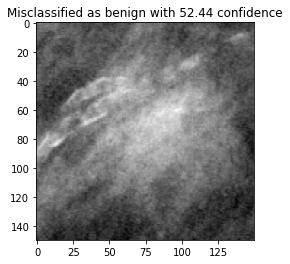

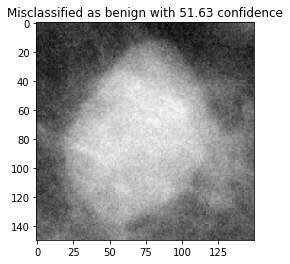

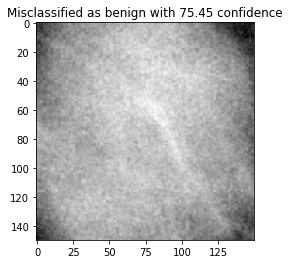

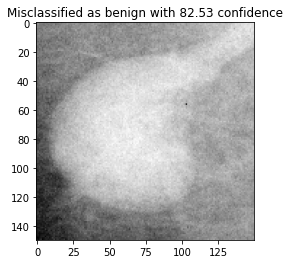

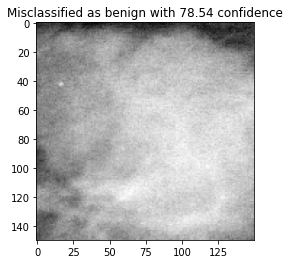

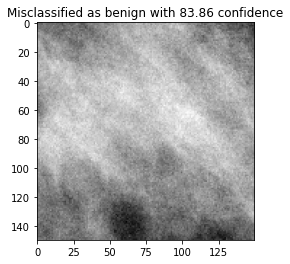

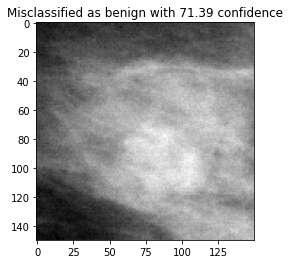

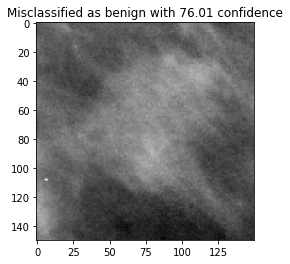

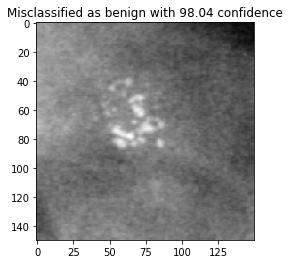

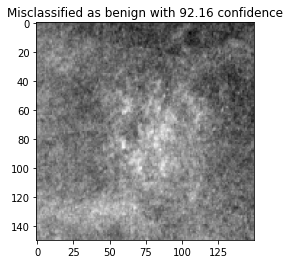

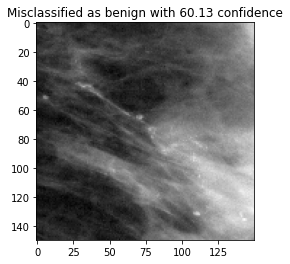

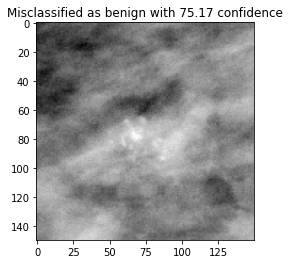

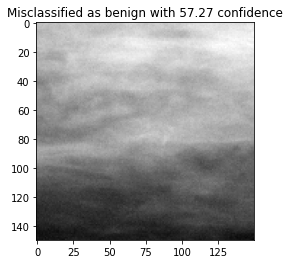

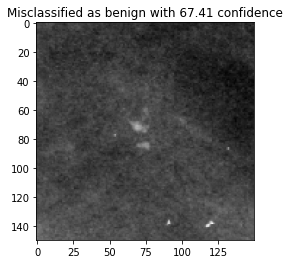

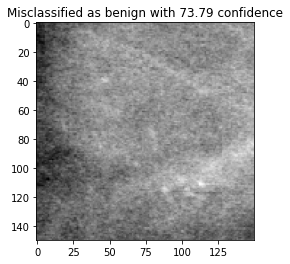

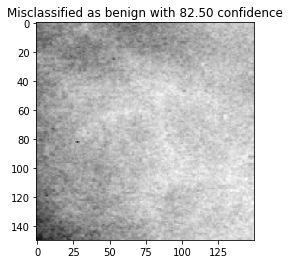

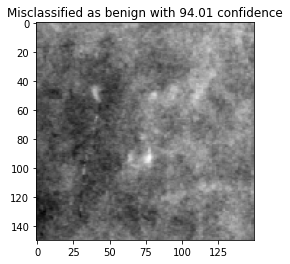

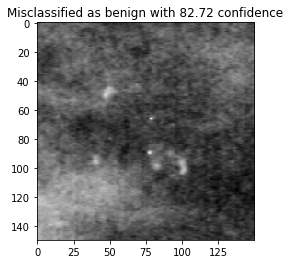

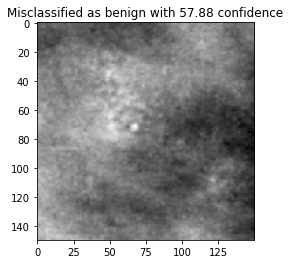

In [ ]:
import seaborn as sns

def get_errors(pred):
    errors = []
    mispred = []

    for l, p, img in zip(resnet_test_generator[0][1], pred, resnet_test_generator[0][0]):
        err = abs(l-p)
        errors.append(err)
        c = 1 if p>0.5 else 0
        if l == 1 and c== 0 and err > 0.5:
            mispred.append((l,p,img))

    return errors, mispred

def show_error_stats(errors, mispred):

    print("Number of test images: %d" % len(resnet_test_generator[0][1]))
    print("Mispredictions: %d" % len(mispred))

    #sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('benign' if l==1 else 'malignant') + ' with %.2f confidence' % (100*abs(p-l)))
        #plt.axis('off')

opt_model = models.load_model(os.path.join(MODEL_PATH, 'resnet3_best.h5'))
pred_opt = opt_model.predict(resnet_test_generator[0][0])
errors, mispred = get_errors(pred_opt)
show_error_stats(errors, mispred)